In [381]:
# Standard library imports
from typing import TypedDict, Annotated
from typing_extensions import Literal, Union

from pydantic import BaseModel, Field
from IPython.display import Image

from uuid import UUID, uuid4
from pprint import pp as pprint

from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers.string import StrOutputParser
from langchain_text_splitters import CharacterTextSplitter

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langgraph.checkpoint.memory import MemorySaver

In [382]:
from prompts.prompts import language_translation_system_prompt
from collections import defaultdict


In [386]:
llm_fast = ChatOpenAI(model="gpt-4o-mini")
llm_slow = ChatOpenAI(model="gpt-4o")
llm_anthropic = ChatAnthropic(model="claude-3-5-sonnet-20241022")

In [387]:
langage_translation_prompt = ChatPromptTemplate(
    [
        ('system',language_translation_system_prompt),
        ('human','{input}')
     ]
)

chain = langage_translation_prompt | llm_anthropic | StrOutputParser()

In [388]:
def set_translation(state: dict, translation: tuple) -> dict:
    key, value = translation
    state[key] = value
    return state

def string_extender(existing_dict: dict, new_value: tuple) -> dict:
    key, value = new_value
    if key in existing_dict:
        existing_dict[key] = existing_dict[key] + value  # Append to existing string
    else:
        existing_dict[key] = value  # Create new entry
    return existing_dict


def replace(s:str)->str:
    return s



In [389]:
class State(BaseModel):
    languages: list[str] = Field(default_factory=list,description="The languages to use to translate")

    original_text: str = ""

    translations: dict = Field(default_factory=dict)
    character_split: str = "\n"
    chunk_size: int = 2000

class TranslateFullState(BaseModel):
    language: str = ""
    original_text: str =""
    character_split: str = "\n"
    chunk_size: int = 2000

    translations_d : Annotated[dict,string_extender] = Field(default_factory=dict)

class TranslatePartState(BaseModel):
    character_split: str = "\n"
    language: str = ""
    text: str = "" 
    index: int 

In [399]:
def send_translation_requests(state: State):
    #print(state.languages)

    send_list = []
    for language in state.languages:
        text_splitter= CharacterTextSplitter(
            separator=state.character_split,
            chunk_size=5,#state.chunk_size,
            chunk_overlap=0,
            length_function=len,
            is_separator_regex=False
        )   
        #print(state)
        #print("language:", language)
        documents = text_splitter.create_documents(
            [state.original_text]
        )
        send_list += [Send("translate_chunk",{"language":language,
                        "text":page.page_content,
                        "index":i,
                        "character_split":state.character_split}) for i,page in enumerate(documents)]
    print("SEND LIST IS: ", send_list)
    return send_list

def placeholder(state:TranslateFullState):
    #print(state)
    return {}

def send_chunks(state:TranslateFullState):
    
    text_splitter= CharacterTextSplitter(
        separator=state.character_split,
        chunk_size=2000,#state.chunk_size,
        chunk_overlap=0,
        length_function=len,
        is_separator_regex=False
    )
    #print(state)
    print("language:", state.language)
    documents = text_splitter.create_documents(
        [state.original_text]
    )

    return [ 
        Send("translate_chunk",{"language":state.language,
                        "text":page.page_content,
                        "index":i}) for i,page in enumerate(documents)
    ]


def translate_chunk(state: TranslatePartState):

    state = TranslatePartState(**state)
    chunk = state.text
    language = state.language 

    output = chain.invoke({"language":language,"input":chunk})

    return { 
        "translations_d": (language,output+state.character_split)
    }


def combine_chunks(state: TranslateFullState):
    return {
        "translations":state.translations_d
        }

In [400]:
builder = StateGraph(State)


In [401]:

builder.add_node("translate_chunk",translate_chunk)
builder.add_node("combine_chunks",combine_chunks)
#builder.add_node("placeholder",placeholder)

builder.add_conditional_edges(START,send_translation_requests,{"translate_chunk":"translate_chunk"}) # unless we cna combine state sends? 
#builder.add_conditional_edges("placeholder",send_chunks,{}"translate_chunk"])
builder.add_edge("translate_chunk","combine_chunks")
builder.add_edge("combine_chunks",END)


In [402]:
memory = MemorySaver()
thread_config = {"configurable": {"thread_id": uuid4()}}
graph = builder.compile(checkpointer=memory)

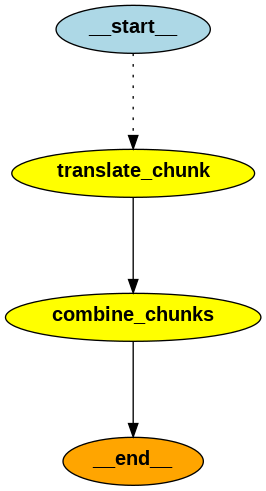

In [403]:
Image(graph.get_graph().draw_png())

## Lets try it

In [404]:
text = """
The Metamorphosis might not "click" unless you've experienced the kind of dissociation from reality Kafka is describing. 
It also requires you to read the story abstractly—it’s less about what happens and more about how it happens, or why it happens. 
If you’re looking for a straightforward story, Kafka’s stuff will probably frustrate you, because the disorienting, anxious effect 
is intentional.

Kafka’s work explores alienation, anxiety, and seeking meaning in a universe that seemingly lacks any. 
There are a bunch of ways to pick through those themes: What is alienation? Is it personal, social, moral, practical, etc? 
That is, is Gregor a “monstrous vermin/bug” because of anything he did—or because of how he thinks about himself—or how his 
family thinks about and treats him—or how society treats him—or for genuine practical reasons, like the way his “metamorphosis” 
impairs his body and physical abilities? The metamorphosis is a source of anxiety—but is it really? Is it the actual change itself 
that causes Gregor anxiety, or is it the expectations he places on himself (e.g. the clash of trying to do his old normal job as 
if he still had his old normal body), or is it the expectations his family/society places on him? Is the metamorphosis really as 
meaningless and random as it seems? Or is it a reflection of something deeper? After all, his family seems mildly shocked at first, 
but all things considered they go back to treating him roughly the same as before. One of the messages you could take from the Metamorphosis 
is that every “random/meaningless shock” in your conception of reality is actually a wake up call, a reflection of a deeper reality you have 
been able to ignore so far by keeping busy with the surface practicalities. Or you could read it as a black comedy. Or an absurd tragedy. 
Or etc. It might be easier to focus less on what the story says, and more on how you read it, and why you read it that way, and what 
that can tell you about yourself.
"""

In [405]:
initial_state = {
    "character_split":".",
    "languages":["Albanian","Italian","French"],
    "original_text":text,
}

In [406]:
output_state = graph.invoke(initial_state,config=thread_config)

Created a chunk of size 120, which is longer than the specified 5
Created a chunk of size 129, which is longer than the specified 5
Created a chunk of size 148, which is longer than the specified 5
Created a chunk of size 103, which is longer than the specified 5
Created a chunk of size 589, which is longer than the specified 5
Created a chunk of size 394, which is longer than the specified 5
Created a chunk of size 276, which is longer than the specified 5
Created a chunk of size 39, which is longer than the specified 5
Created a chunk of size 21, which is longer than the specified 5
Created a chunk of size 8, which is longer than the specified 5
Created a chunk of size 159, which is longer than the specified 5
Created a chunk of size 120, which is longer than the specified 5
Created a chunk of size 129, which is longer than the specified 5
Created a chunk of size 148, which is longer than the specified 5
Created a chunk of size 103, which is longer than the specified 5
Created a chun

SEND LIST IS:  [Send(node='translate_chunk', arg={'language': 'Albanian', 'text': 'The Metamorphosis might not "click" unless you\'ve experienced the kind of dissociation from reality Kafka is describing', 'index': 0, 'character_split': '.'}), Send(node='translate_chunk', arg={'language': 'Albanian', 'text': 'It also requires you to read the story abstractly—it’s less about what happens and more about how it happens, or why it happens', 'index': 1, 'character_split': '.'}), Send(node='translate_chunk', arg={'language': 'Albanian', 'text': 'If you’re looking for a straightforward story, Kafka’s stuff will probably frustrate you, because the disorienting, anxious effect \nis intentional', 'index': 2, 'character_split': '.'}), Send(node='translate_chunk', arg={'language': 'Albanian', 'text': 'Kafka’s work explores alienation, anxiety, and seeking meaning in a universe that seemingly lacks any', 'index': 3, 'character_split': '.'}), Send(node='translate_chunk', arg={'language': 'Albanian',

In [408]:
print(output_state['translations']['Albanian'])

"Metamorfoza" ndoshta nuk do të ketë kuptim për ty, përveç nëse e ke përjetuar vetë atë shkëputje nga realiteti që përshkruan Kafka.Gjithashtu kërkon që ta lexosh historinë në mënyrë abstrakte - nuk është aq shumë se çfarë ndodh, por më tepër se si ndodh, ose pse ndodh.Nëse je duke kërkuar një histori të thjeshtë e të drejtpërdrejtë, veprat e Kafkës me siguri do të të bëjnë nervoz, sepse ndjenja e humbjes së drejtimit dhe ankthit është e qëllimshme.Veprat e Kafkës hulumtojnë ndjenjën e huajësimit, ankthin dhe kërkimin e kuptimit në një gjithësi që në dukje nuk ka asnjë domethënie.Ka shumë mënyra për të analizuar këto tema: Çfarë është tjetërsimi? A është personal, shoqëror, moral, praktik e kështu me radhë? 
Domethënë, a është Gregori një "insekt i neveritshëm" për shkak të diçkaje që ka bërë - apo për mënyrën se si e sheh veten - apo për mënyrën 
se si familja e tij mendon dhe sillet me të - apo për mënyrën se si shoqëria e trajton - apo për arsye thjesht praktike, si mënyra se si 
"m